# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [42]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection
from scipy.stats import randint as sp_randint

In [43]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")

display(X)
display(y)

#chequeo de escalas
display(np.amax(X,axis=0))
display(np.amin(X,axis=0))


# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


0      2.9702
1      2.7920
2      2.6905
3      2.8091
4      2.9823
        ...  
195    2.9109
196    2.4942
197    3.1804
198    3.0034
199    2.5107
Length: 200, dtype: float64

0     -3.1722
1     -2.4596
2     -2.8834
3     -3.7474
4     -2.9987
        ...  
195   -2.5163
196   -3.9278
197   -2.4254
198   -2.6234
199   -2.8690
Length: 200, dtype: float64

## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

X_dev: (400, 200), y_dev: (400, 1) para desarrollo
X_eval: (100, 200), y_eval: (100, 1) para evaluación
Proporcion Aptos: 0.4575


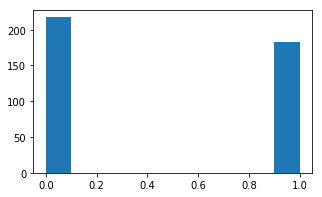

In [44]:
# EJERCICIO 1. 


########################################################
np.random.seed(1234)
X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, stratify=y, test_size = 1/5)

# X_eval y_eval: son el heldout, separados usando la misma proporcion de malos y buenos, y shuffleando. DEF 

#########################################################


print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))
print("Proporcion Aptos:", np.array(y_dev).sum()/np.array(y_dev).shape[0] )
plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()

### Splitting

Se decidio utilizar un 20% de los datos como conjunto de Held-Out. Se utlizó el argumento stratify=y para mantener la proporcion de categorías de y en el split. El conjunto Held-Out permanecerá incorrupto hasta el final del experimento.


## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

In [45]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
## AQUI VA SU CODIGO
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados

# Hacer arbol
# (Separar en KFold)
# Iterar por cada fold: fitear arbol, calcular accuracies y aucs en training y validation y guardarlos

arbol = DecisionTreeClassifier(max_depth=3)
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
scores = sklearn.model_selection.cross_validate(arbol, X_dev_np, y_dev_np, cv = cv,
                                                scoring=['accuracy', 'roc_auc'], return_train_score=True)

#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = scores['train_accuracy']     # cambiar por accuracies_training
df["Accuracy (validación)"] = scores['test_accuracy']   # cambiar por accuracies_validation
df["AUC ROC (training)"] = scores['train_roc_auc']      # cambiar por aucs_training
df["AUC ROC (validación)"] = scores['test_roc_auc']    # cambiar por aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
#df.plot(kind="bar")
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
#plt.show()

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8213,0.6667,0.8806,0.7294
2,0.8621,0.6296,0.8971,0.6345
3,0.8250,0.6625,0.8807,0.7266
4,0.8255,0.6709,0.8852,0.7377
5,0.8287,0.5696,0.8701,0.6247


In [46]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
# np.random.seed(SEED)
# for criterio in ["gini", "entropy"]:
#     for altura in [3, 5, None]:
#         CODIGO AQUI.
#         resultados_training.append( <RESULTADO_TRAINING> )
#         resultados_validation.append( <RESULTADO_VALIDATION> )

for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        arbol = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
        np.random.seed(1234) # lo pongo aca para que todos tengan los mismos k-folds
        cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True)
        scores = sklearn.model_selection.cross_validate(arbol, X_dev_np, y_dev_np, cv = cv, 
                                                        scoring=['roc_auc'], return_train_score=True)
        resultados_training.append( scores['train_roc_auc'].mean() )
        resultados_validation.append( scores['test_roc_auc'].mean() )

#########################################################


df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation


display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8827,0.6906
1,5,Gini,0.9832,0.6442
2,Inifinito,Gini,1.0000,0.6265
3,3,Ganancia de Información,0.8606,0.7239
4,5,Ganancia de Información,0.9692,0.6596
5,Inifinito,Ganancia de Información,1.0000,0.6162


## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

def top_resultados(grid, top=10):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

########################################################
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba
########################################################

### KNN

In [48]:
##### KNN PARAMETERS
# n_neighbors Number of neighbors
# p=1 Manhattan_distance
# p=2 Euclidean_distance (l2) 
# p=!1 y 2 Minkowski_distance(p)
# weights='uniform' All points in each neighborhood are weighted equally
# weights='distance' Weight points by the inverse of their distance
### como minkowski es la metrica default usando solo p puedo simular las otras mas usuales. 
### Los demas no los usamos porque son mas de eficiencia algoritmica que de aprendizaje.
knn_grid_parameters = {
    'n_neighbors': [1, 5, 10, 15, 20], 
    'weights': ['uniform', 'distance'],
    'p':[1,2,5]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,n_neighbors,p,weights,mean_score_validation,mean_score_training
27,20,2,distance,0.8172,1.0000
25,20,1,distance,0.8166,1.0000
24,20,1,uniform,0.8162,0.8516
26,20,2,uniform,0.8161,0.8548
29,20,5,distance,0.8141,1.0000
28,20,5,uniform,0.8119,0.8619
21,15,2,distance,0.8112,1.0000
20,15,2,uniform,0.8107,0.8570
19,15,1,distance,0.8048,1.0000
18,15,1,uniform,0.8042,0.8590


In [49]:
##### KNN ITERATION 1
knn_grid_parameters = {
    'n_neighbors': [10, 50, 100, 150], 
    'weights': ['uniform', 'distance'],
    'p':[1,2]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,n_neighbors,p,weights,mean_score_validation,mean_score_training
8,100,1,uniform,0.8369,0.8472
9,100,1,distance,0.8367,1.0000
13,150,1,distance,0.8325,1.0000
7,50,2,distance,0.8325,1.0000
12,150,1,uniform,0.8320,0.8369
15,150,2,distance,0.8317,1.0000
6,50,2,uniform,0.8316,0.8495
14,150,2,uniform,0.8312,0.8381
11,100,2,distance,0.8273,1.0000
10,100,2,uniform,0.8268,0.8406


In [50]:
##### KNN ITERATION 2
knn_grid_parameters = {
    'n_neighbors': [50, 60, 70, 80, 90, 100], 
    'weights': ['uniform', 'distance'],
    'p':[1,2]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,n_neighbors,p,weights,mean_score_validation,mean_score_training
12,80,1,uniform,0.8382,0.8503
13,80,1,distance,0.8380,1.0000
16,90,1,uniform,0.8370,0.8490
20,100,1,uniform,0.8369,0.8472
21,100,1,distance,0.8367,1.0000
17,90,1,distance,0.8366,1.0000
9,70,1,distance,0.8325,1.0000
7,60,2,distance,0.8325,1.0000
3,50,2,distance,0.8325,1.0000
6,60,2,uniform,0.8320,0.8534


In [51]:
##### KNN ITERATION 3
knn_grid_parameters = {
    'n_neighbors': [75, 57, 79, 80, 81, 83, 85, 87, 89, 90, 91, 93, 95], 
    'weights': ['uniform', 'distance'],
    'p':[1,2]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,n_neighbors,p,weights,mean_score_validation,mean_score_training
20,83,1,uniform,0.8401,0.8504
24,85,1,uniform,0.8400,0.8503
21,83,1,distance,0.8393,1.0000
16,81,1,uniform,0.8392,0.8501
25,85,1,distance,0.8389,1.0000
17,81,1,distance,0.8389,1.0000
12,80,1,uniform,0.8382,0.8503
28,87,1,uniform,0.8381,0.8505
13,80,1,distance,0.8380,1.0000
9,79,1,distance,0.8378,1.0000


Al iterar sobre la cantidad de vecinos para determinar el mejor modelo, encontramos un óptimo cercano a ochenta. Es un cuarto de la cantidad total de instancias de entrenamiento y parece ser suficiente para generalizar patrones.
Asimismo, no parece haber mayores diferencias en el score de validación al ponderar por distancia y preferimos un algoritmo que no tenga un score de 1 en el training para evitar sobreajuste.
No parece haber una estructura en los datos que requiera medir la distancia de manera no euclidiana.


### Decision Tree Classifier (DT)

In [52]:
##### Decision Tree Classifier (DT)
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'],
    'max_depth':[3, 5, 10, None],
    'min_samples_split': [2, 5, 10, 20, 30, 50, 70],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 25, 30, 35],
    'max_features': ['sqrt', 'log2', 180, 150, 100, 75, 50, None]
}

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)



Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
2923,gini,10.0,None,2,50,random,0.7954,0.8798
1967,gini,5.0,None,20,20,random,0.7945,0.8531
5475,entropy,5.0,150,15,2,random,0.7917,0.8618
3337,gini,NaN,180,15,10,random,0.7898,0.8768
2588,gini,10.0,100,15,70,best,0.7890,0.8604
2459,gini,10.0,150,15,30,random,0.7889,0.8719
5415,entropy,5.0,180,35,50,random,0.7881,0.8147
5863,entropy,5.0,50,15,50,random,0.7850,0.8225
3971,gini,NaN,None,15,30,random,0.7848,0.8711
6981,entropy,10.0,None,10,30,random,0.7846,0.8945


In [53]:
##### DT ITERATION 1
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'],
    'max_depth':[3, 4],
    'min_samples_split': [2, 3, 4, 5, 6, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5, 10, 15, 20, 25, 30, 35],
    'max_features': ['sqrt', 'log2', 150, 100, 75, 50, None]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
1709,gini,4,100,20,15,random,0.8010,0.8288
2145,gini,4,None,10,2,random,0.7888,0.8752
4421,entropy,4,None,20,4,random,0.7860,0.8347
897,gini,3,50,20,2,random,0.7843,0.8015
3799,entropy,4,150,25,5,random,0.7840,0.8319
4113,entropy,4,75,25,2,random,0.7823,0.8187
2629,entropy,3,150,10,4,random,0.7816,0.8220
52,gini,3,sqrt,5,4,best,0.7804,0.8294
1677,gini,4,100,10,15,random,0.7799,0.8469
4244,entropy,4,50,15,4,best,0.7788,0.8903


In [54]:
##### DT ITERATION 2
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['random', 'best'],
    'max_depth':[3, 4],
    'min_samples_split': [2, 3, 7, 9, 16, 19, 22, 25, 28, 30],
    'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17],
    'max_features': [ 100, 90, 80, 70, 60, 50]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
2220,entropy,3,100,7,2,random,0.8007,0.8262
3556,entropy,4,90,13,28,random,0.7915,0.8429
1098,gini,4,100,1,30,random,0.7822,0.8519
1584,gini,4,80,15,7,random,0.7801,0.8287
310,gini,3,90,13,19,random,0.7783,0.7979
1532,gini,4,80,9,22,random,0.7778,0.8350
254,gini,3,90,7,25,random,0.7774,0.8061
1918,gini,4,60,11,30,random,0.7771,0.8339
2853,entropy,3,70,15,22,best,0.7767,0.8548
2316,entropy,3,100,15,28,random,0.7759,0.8045


In [55]:
##### DT ITERATION 3
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['random'],
    'max_depth':[4, 3],
    'min_samples_split': [2, 7, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32],
    'min_samples_leaf': [1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    'max_features': [100, 95, 90, 85, 80]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
434,gini,4,90,15,19,random,0.7993,0.8235
1704,entropy,4,100,17,2,random,0.7901,0.8326
430,gini,4,90,14,31,random,0.7882,0.8529
883,gini,3,100,13,28,random,0.7880,0.7933
1857,entropy,4,95,16,30,random,0.7864,0.8239
750,gini,4,80,15,27,random,0.7842,0.8316
2158,entropy,4,85,15,31,random,0.7840,0.8384
279,gini,4,95,15,20,random,0.7833,0.8429
2021,entropy,4,90,17,22,random,0.7830,0.8360
2680,entropy,3,90,7,21,random,0.7820,0.7888


In [56]:
##### DT ITERATION 4
dt_grid_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['random'],
    'max_depth':[4, 3],
    'min_samples_split': [2, 7, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32],
    'min_samples_leaf': [12, 13, 14, 15, 16, 17, 18],
    'max_features': [100, 98, 96, 94, 92, 90, None]
}
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

#best_dt: criterion='gini', 'max_depth':4 , 'max_features' : 90, min_samples_leaf= 13,  min_samples_split= 19, splitter ='random'

Top 10 combinaciones


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_score_validation,mean_score_training
434,gini,4,90.0,13,19,random,0.8055,0.8271
430,gini,4,90.0,12,31,random,0.7986,0.8536
81,gini,4,100.0,18,30,random,0.7876,0.8351
1402,entropy,4,96.0,16,31,random,0.7870,0.8321
1927,entropy,3,98.0,18,28,random,0.7844,0.8041
2337,entropy,3,NaN,17,30,random,0.7826,0.8273
661,gini,3,100.0,18,7,random,0.7803,0.8011
1740,entropy,4,NaN,17,2,random,0.7802,0.8553
646,gini,3,100.0,16,31,random,0.7796,0.8011
1119,gini,3,NaN,14,20,random,0.7777,0.8157


El criterio Gini fue el mejor para construir el modelo. Por otro lado usar un mínimo de samples por hoja y para hacer split también sirvió. Creemos que de esta manera evitamos el sobre ajuste lo cual mejora el desempeño del modelo. De la misma manera contribuye limitar la profundidad máxima del arbol. Tambien se evidencia mejoras en el modelo utilizando baja profundidad maxima, esto ocurre ya que a mayor profundidad que a utilizada parece ocurrir overfitting, ademas encontramos  que usar un numero de features de aproximadamente 90, mejora la exactitud, o por lo menos no la perjudica, esto podria indicar que muchos de los atributos de nuestros minions no son relevantes a si son aptos o no.

### LDA

In [57]:
warnings.simplefilter(action='ignore')
##### LDA PARAMETERS
lda_grid_parameters = [{
    'solver': ['lsqr', 'eigen'], 
    'shrinkage': ['auto', 0.1, 0.25, 0.50, 0.75, 0.85, 0.9, 1.0],
    'priors': [None, [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4], [0.7, 0.3] ]
}, {
    'solver': ['svd'], 
    'tol': [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0],
    'priors': [None, [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4], [0.7, 0.3] ]
}]
# svd no usa shrinkage, si  usa tol

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=lda_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,priors,shrinkage,solver,tol,mean_score_validation,mean_score_training
89,"[0.7, 0.3]",0.75,eigen,NaN,0.8386,0.9323
91,"[0.7, 0.3]",0.85,eigen,NaN,0.8382,0.9105
88,"[0.7, 0.3]",0.75,lsqr,NaN,0.8378,0.9353
74,"[0.6, 0.4]",0.85,lsqr,NaN,0.8369,0.9134
72,"[0.6, 0.4]",0.75,lsqr,NaN,0.8367,0.9371
93,"[0.7, 0.3]",0.9,eigen,NaN,0.8366,0.8958
10,None,0.85,lsqr,NaN,0.8365,0.9135
58,"[0.5, 0.5]",0.85,lsqr,NaN,0.8365,0.9138
90,"[0.7, 0.3]",0.85,lsqr,NaN,0.8365,0.9123
11,None,0.85,eigen,NaN,0.8362,0.9141


In [58]:
##### LDA ITERATION 1
lda_grid_parameters = {
    'solver': ['lsqr', 'eigen'], 
    'shrinkage': [0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
    'priors': [ None, [0.55, 0.45], [0.6, 0.4], [0.65, 0.35], [0.7, 0.3],
               [0.75, 0.25], [0.8, 0.2], [0.85, 0.15], [0.9, 0.1] ]

}
    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=lda_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)


Top 10 combinaciones


,priors,shrinkage,solver,mean_score_validation,mean_score_training
77,"[0.8, 0.2]",0.75,eigen,0.8412,0.9259
89,"[0.85, 0.15]",0.75,eigen,0.8410,0.9224
67,"[0.75, 0.25]",0.80,eigen,0.8409,0.9198
102,"[0.9, 0.1]",0.80,lsqr,0.8407,0.9205
79,"[0.8, 0.2]",0.80,eigen,0.8407,0.9169
105,"[0.9, 0.1]",0.85,eigen,0.8405,0.9013
103,"[0.9, 0.1]",0.80,eigen,0.8405,0.9105
101,"[0.9, 0.1]",0.75,eigen,0.8402,0.9188
91,"[0.85, 0.15]",0.80,eigen,0.8402,0.9137
104,"[0.9, 0.1]",0.85,lsqr,0.8400,0.9097


In [59]:
##### LDA ITERATION 2
lda_grid_parameters = {
    'solver': ['lsqr', 'eigen'], 
    'shrinkage': [0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85],
    'priors': [[0.75, 0.25], [0.78, 0.22], [0.8, 0.2], [0.83, 0.17], [0.85, 0.15], [0.88, 0.12], [0.9, 0.1] ]

}
    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=lda_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,priors,shrinkage,solver,mean_score_validation,mean_score_training
124,"[0.88, 0.12]",0.82,lsqr,0.8414,0.9168
103,"[0.85, 0.15]",0.82,eigen,0.8414,0.9098
125,"[0.88, 0.12]",0.82,eigen,0.8414,0.9082
101,"[0.85, 0.15]",0.81,eigen,0.8412,0.9118
45,"[0.8, 0.2]",0.75,eigen,0.8412,0.9259
146,"[0.9, 0.1]",0.82,lsqr,0.8411,0.9164
37,"[0.78, 0.22]",0.82,eigen,0.8411,0.9140
145,"[0.9, 0.1]",0.81,eigen,0.8411,0.9089
123,"[0.88, 0.12]",0.81,eigen,0.8411,0.9102
73,"[0.83, 0.17]",0.78,eigen,0.8411,0.9186


No hay diferencias al usar como solver a "lsqr" o "eigen", "svd" lo descartamos por que tuvo un bajo desempeño. Por otro lado el modelo mejora considerablemente  al condicionar los priors de proporciones de las clases y al asignarle un shrinkage. En el caso de las priors, encontramos extraño que mejore asignandole distribuciones lejanas a la registrada en la muestra(cercana al 50%), la cual tambien es la distribucion del conjunto de validacion, esto puede indicar que la distribucion original de minion no es la misma que presenta la muestra. Creemos que con shrinkage mejora ya que es posible que la cantidad de instancias sea baja en función de la cantidad de atributos de este set de datos.

### Naive Bayes

In [60]:
#### Naive Bayes
nb_grid_parameters = {
    'priors': [[0.05, 0.95], [0.95, 0.05],[0.75, 0.25], [0.25, 0.75], [0.50, 0.50], None],
}

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(GaussianNB(), param_grid=nb_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)


Top 10 combinaciones


,priors,mean_score_validation,mean_score_training
1,"[0.95, 0.05]",0.8207,0.8687
2,"[0.75, 0.25]",0.8203,0.8684
3,"[0.25, 0.75]",0.8201,0.8680
4,"[0.5, 0.5]",0.8199,0.8685
5,None,0.8199,0.8684
0,"[0.05, 0.95]",0.8193,0.8680


Consideramos que la mejora obtenida por cambiar de prior=None a prior=[0.95, 0.05] es poca y no amerita realizar una suposición tan fuerte.
La distribución de clases en la muestra que tenemos es cercana al 50%. Lo más parsimonioso es que este hiparámetro se determine a partir de la muestra.

### SVC

In [61]:
#### Support Vector Classification para valores de C "bajos" [< 1 (default)]

svc_grid_parameters ={
    'C': [0.001, 0.1, 0.5],
    'max_iter': [50, 250, 500, 1000, 1500, 2000],
    'loss':['hinge', 'squared_hinge'],
    'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    }

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearSVC(), param_grid=svc_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)



Top 10 combinaciones


,C,loss,max_iter,tol,mean_score_validation,mean_score_training
29,0.001,hinge,2000,1.0000e-02,0.8385,0.9065
0,0.001,hinge,50,1.0000e-06,0.8384,0.9066
15,0.001,hinge,1000,1.0000e-06,0.8384,0.9066
1,0.001,hinge,50,1.0000e-05,0.8384,0.9066
27,0.001,hinge,2000,1.0000e-04,0.8384,0.9066
26,0.001,hinge,2000,1.0000e-05,0.8384,0.9066
25,0.001,hinge,2000,1.0000e-06,0.8384,0.9066
24,0.001,hinge,1500,1.0000e-02,0.8384,0.9066
23,0.001,hinge,1500,1.0000e-03,0.8384,0.9066
21,0.001,hinge,1500,1.0000e-05,0.8384,0.9066


In [62]:
#### Support Vector Classification para valores de C no muy "bajos" y "altos" [ > 1 (default)]

svc_grid_parameters ={
    'C': [0.1, 0.5, 0.75, 1, 1.50, 1.75],
    'max_iter': [50, 250, 500, 1000, 1500, 2000], 
    'loss':['hinge', 'squared_hinge'],
    'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    } 

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearSVC(), param_grid=svc_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,C,loss,max_iter,tol,mean_score_validation,mean_score_training
2,0.1,hinge,50,1.0000e-04,0.7569,0.9958
0,0.1,hinge,50,1.0000e-06,0.7566,0.9954
6,0.1,hinge,250,1.0000e-05,0.7565,0.9959
7,0.1,hinge,250,1.0000e-04,0.7565,0.9959
19,0.1,hinge,1000,1.0000e-02,0.7565,0.9959
24,0.1,hinge,1500,1.0000e-02,0.7565,0.9959
16,0.1,hinge,1000,1.0000e-05,0.7564,0.9959
28,0.1,hinge,2000,1.0000e-03,0.7564,0.9959
27,0.1,hinge,2000,1.0000e-04,0.7564,0.9959
26,0.1,hinge,2000,1.0000e-05,0.7564,0.9959


In [63]:
#SVC iter 1

svc_grid_parameters ={
    'C': [0.001, 0.005, 0.0005, 0.0001, 0.00001, 0.000001],
    'max_iter': [50,100, 2000],
    'loss':['hinge'],
    'tol': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
    }

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(LinearSVC(), param_grid=svc_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)


Top 10 combinaciones


,C,loss,max_iter,tol,mean_score_validation,mean_score_training
11,0.001,hinge,100,0.40,0.8388,0.9066
16,0.001,hinge,2000,0.30,0.8388,0.9063
8,0.001,hinge,100,0.10,0.8388,0.9065
9,0.001,hinge,100,0.20,0.8386,0.9065
15,0.001,hinge,2000,0.20,0.8386,0.9064
7,0.001,hinge,100,0.01,0.8385,0.9066
17,0.001,hinge,2000,0.40,0.8384,0.9066
10,0.001,hinge,100,0.30,0.8384,0.9064
5,0.001,hinge,50,0.40,0.8384,0.9065
4,0.001,hinge,50,0.30,0.8384,0.9065


Por como se describe al parametro C en la documentación, a menores valores de C el hiperplano que separa las instancias es mas permisivo. Es decir permite errores de clasificación en los margenes cercanos al hiperplano. Creemos que los datos no pueden ser separados de manera perfecta con un hiperplano, ya que las instancias se encuentran muy mezcladas. Por eso es necesario aumentar la tolerancia. Los resultados obtenidos tambien podrian indicar que  nuestros atribitos son dependientes entre si, y que no siguen una distribucion normal. Lo que podria sugerir usar un preprocesamiento de nuestro datos, como por ejemplo PCA.  

### Conclusiones Grid Search



## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. **Construir** un modelo RandomForest con 200 árboles. **Explorar** para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. **Explicar** por qué creen que se dieron los resultados obtenidos. Por último, **graficar** una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




In [64]:
# Funcion para graficar curva de aprendizaje y curva de complejidad
def plot_curve(title,param_name,param_range,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std):
    
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    


#### Curvas de complejidad

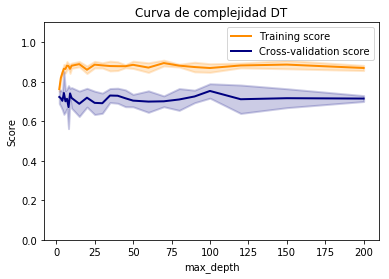

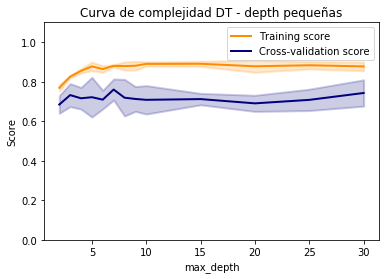

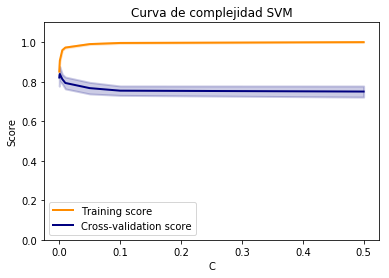

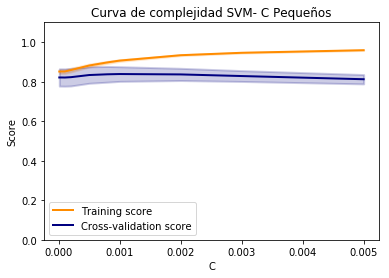

In [65]:
##### Curvas de complejidad
    #Para DT variando profundidad
                                                    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
param_name='max_depth'
param_range=[2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45, 50, 60, 70, 80, 90, 100, 120, 150, 200]
cc_train_scores, cc_valid_scores = sklearn.model_selection.validation_curve(
    DecisionTreeClassifier(criterion='gini', splitter ='random',min_samples_split=50, 
                           min_samples_leaf=2,max_features=None),X_dev_np, y_dev_np, 
    param_name=param_name, param_range=param_range, cv = cv, scoring='roc_auc')
                                                    
cc_train_scores_mean = np.mean(cc_train_scores, axis=1)
cc_train_scores_std = np.std(cc_train_scores, axis=1)
cc_test_scores_mean = np.mean(cc_valid_scores, axis=1)
cc_test_scores_std = np.std(cc_valid_scores, axis=1)

plot_curve("Curva de complejidad DT",param_name,param_range,
           cc_train_scores_mean,cc_train_scores_std,cc_test_scores_mean,cc_test_scores_std)

##DT 
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
param_name='max_depth'
param_range=[2,3,4,5,6,7,8,9,10,15,20,25,30]
cc_train_scores, cc_valid_scores = sklearn.model_selection.validation_curve(
    DecisionTreeClassifier(criterion='gini', splitter ='random',min_samples_split=50, 
                           min_samples_leaf=2,max_features=None),X_dev_np, y_dev_np, 
    param_name=param_name, param_range=param_range, cv = cv, scoring='roc_auc')
                                                    
cc_train_scores_mean = np.mean(cc_train_scores, axis=1)
cc_train_scores_std = np.std(cc_train_scores, axis=1)
cc_test_scores_mean = np.mean(cc_valid_scores, axis=1)
cc_test_scores_std = np.std(cc_valid_scores, axis=1)

plot_curve("Curva de complejidad DT - depth pequeñas",param_name,param_range,
           cc_train_scores_mean,cc_train_scores_std,cc_test_scores_mean,cc_test_scores_std)
    #Para SVM variando C

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
param_name='C'
param_range=[0.0001,0.0005,0.001,0.005, 0.01,0.05, 0.1, 0.5]
cc_train_scores, cc_valid_scores = sklearn.model_selection.validation_curve(
    LinearSVC(max_iter=2000, loss='hinge', tol=0.4),X_dev_np, y_dev_np,
    param_name=param_name, param_range=param_range, cv = cv, scoring='roc_auc')
                                                    
cc_train_scores_mean = np.mean(cc_train_scores, axis=1)
cc_train_scores_std = np.std(cc_train_scores, axis=1)
cc_test_scores_mean = np.mean(cc_valid_scores, axis=1)
cc_test_scores_std = np.std(cc_valid_scores, axis=1)

plot_curve("Curva de complejidad SVM",param_name,param_range,cc_train_scores_mean,cc_train_scores_std,
           cc_test_scores_mean,cc_test_scores_std)

#Svm en detalle

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
param_name='C'
param_range=[0.00001,0.00005,0.0001,0.0002,0.0005,0.0008, 0.001, 0.002, 0.003, 0.005]
cc_train_scores, cc_valid_scores = sklearn.model_selection.validation_curve(
    LinearSVC(max_iter=2000, loss='hinge', tol=0.4),X_dev_np, y_dev_np,
    param_name=param_name, param_range=param_range, cv = cv, scoring='roc_auc')
                                                    
cc_train_scores_mean = np.mean(cc_train_scores, axis=1)
cc_train_scores_std = np.std(cc_train_scores, axis=1)
cc_test_scores_mean = np.mean(cc_valid_scores, axis=1)
cc_test_scores_std = np.std(cc_valid_scores, axis=1)

plot_curve("Curva de complejidad SVM- C Pequeños",param_name,param_range,cc_train_scores_mean,cc_train_scores_std,
           cc_test_scores_mean,cc_test_scores_std)
    

En el caso de arboles a mayor profundidad (mayor complejidad) la varianza aumenta. Esto se evidencia en el aumento de la diferencia entre ambas curvas a medida. Por otro lado el sesgo disminuye a medida que aumenta la profundidad del arbol (observado como un training score mas alto).
Esto evidencia que un arbol más profundo se ajusta muy bien a los datos de entrenamiento (bajo sesgo), pero no logra generalizar y falla al clasificar datos de validación (alta varianza). Y viceversa si es menos profundo. 

En el caso de SVM, vemos como el sesgo aumenta (menor training score) y la varianza disminuye (poca diferencia entre training score CV score) cuando el parametro C toma valores cercanos al cero. Contrariamente, a valores elevados de C, el sesgo disminuye y la varianza aumenta. Nos llama la atención que este resultado es contrario al que esperamos si tomamos en cuenta la definición y descripción del parámetro C dada en el libro **An Introduction to Statistical Learning with applications in R**. Aquí se describe a C como un parámetro que condiciona la permisividad de errores de clasificación en los margenes del hyperplano y mas allá de este. Entonces, a valores elevados del parámetro C se obtienen modelos con menor varianza.

Como el parámetro C se define en la dcumentación como "parámetro de penalidad del error", creemos que en la implementación del algoritmo, C es la inversa del parámetro C descripto en el libro.

#### Curvas de aprendizaje

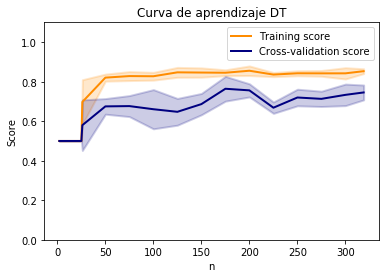

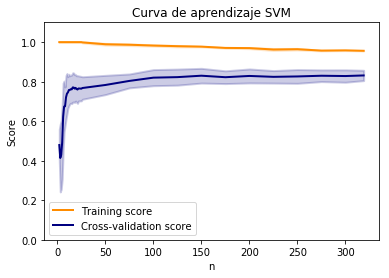

In [66]:
#### Curvas de aprendizaje
#train_sizes, train_scores, valid_scores = learning_curve(
#...     SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)
train_sizes=[2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18,19, 20,21,22,25,26, 50, 75, 100,125, 150, 175, 200, 225, 250, 275, 300, 319]

# 

    
    
    
    #Para DT

#best_dt: criterion='gini', 'max_depth':4 , 'max_features' : 90, min_samples_leaf= 13,  min_samples_split= 19, splitter ='random'
    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
ca_train_sizes, ca_train_scores, ca_valid_scores = sklearn.model_selection.learning_curve(DecisionTreeClassifier(
    criterion='gini', splitter ='random', min_samples_split=19, min_samples_leaf=13,
    max_features=90,max_depth=4), X_dev_np, y_dev_np, train_sizes=train_sizes, cv=cv, scoring='roc_auc')
# min_samples_split=19, min_samples_leaf=13,
    
ca_train_scores_mean = np.mean(ca_train_scores, axis=1)
ca_train_scores_std = np.std(ca_train_scores, axis=1)
ca_test_scores_mean = np.mean(ca_valid_scores, axis=1)
ca_test_scores_std = np.std(ca_valid_scores, axis=1)
    
plot_curve("Curva de aprendizaje DT",'n',ca_train_sizes,ca_train_scores_mean,
           ca_train_scores_std,ca_test_scores_mean,ca_test_scores_std)

   
    
    
    
    #Para SVM
    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
ca_train_sizes, ca_train_scores, ca_valid_scores = sklearn.model_selection.learning_curve(
    LinearSVC(max_iter=50,C=0.001), X_dev_np, y_dev_np, train_sizes=train_sizes, cv=cv, scoring='roc_auc')
    
ca_train_scores_mean = np.mean(ca_train_scores, axis=1)
ca_train_scores_std = np.std(ca_train_scores, axis=1)
ca_test_scores_mean = np.mean(ca_valid_scores, axis=1)
ca_test_scores_std = np.std(ca_valid_scores, axis=1)
    
plot_curve("Curva de aprendizaje SVM",'n',train_sizes,ca_train_scores_mean,ca_train_scores_std,
           ca_test_scores_mean,ca_test_scores_std)
    


Para el caso de DT, las curvas de aprendizaje se estabilizan luego de que la muestra supera las 50 instacias (aprox). Para $n < 26$, por los hiperparámetros elegidos, no puede generar un árbol de más de un nodo entonces no logra clasificar en más de una categoría y el score es de 0.5.  
Por otro lado, para el caso de  SVM la curva de aprendizaje (para el CV) llega a un pateau cuando el $n > 10$.
Si bien parece haber una leve tendencia de aumento en las curvas de CV, como el error es grande, consideramos que la performance de ambos modelos no aumenta: parecen haber alcanzado su límite. 

#### Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

#RandomForest
    # Construyo con 200 árboles
    # Veo desempeño modelo con cross-validation

    #Curva de complejidad variando max_features
    #Curva de aprendizaje
    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
rForest = RandomForestClassifier(n_estimators = 200)
scores = sklearn.model_selection.cross_validate(rForest, X_dev_np, y_dev_np, cv = cv,
                                                scoring='roc_auc', return_train_score=True)


# Hago tabla con resultados del CV
df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
df["AUC ROC (training)"] = scores['train_score']     
df["AUC ROC (validación)"] = scores['test_score']    

display(HTML("<h3> TABLA 1 </h3>"))
display(df)

print("Media AUC-ROC (validación): {}".format(np.mean(scores['test_score'] )))


,AUC ROC (training),AUC ROC (validación)
Permutación,,
1,1.0,0.8633
2,1.0,0.7386
3,1.0,0.8712
4,1.0,0.8366
5,1.0,0.7907


Media AUC-ROC (validación): 0.8200753607730352


¿Que pasa si variamos **max_features**?

In [68]:
# Random Forest variando 'max_features'

rForest_grid_parameters ={
    'max_features' : ['sqrt','log2',1, 2, 5, 10, 20, 30, 40, 50, 100, 125, 150, 175, None], 
    'n_estimators': [10, 50, 100, 200]
}

np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
grid = GridSearchCV(RandomForestClassifier(), param_grid= rForest_grid_parameters, cv=cv, scoring='roc_auc')
grid.fit(X_dev_np, y_dev_np)
top_resultados(grid)

Top 10 combinaciones


,max_features,n_estimators,mean_score_validation,mean_score_training
1,sqrt,50,0.8317,1.0
30,30,100,0.8313,1.0
23,10,200,0.8312,1.0
39,50,200,0.8309,1.0
31,30,200,0.8292,1.0
26,20,100,0.8288,1.0
27,20,200,0.8287,1.0
3,sqrt,200,0.8286,1.0
19,5,200,0.8282,1.0
18,5,100,0.8279,1.0


Obtenemos un mejor resultado si limitamos **'max_features' = 50 **.

Pero ¿cómo afecta este parámetro a la curva de complejidad?

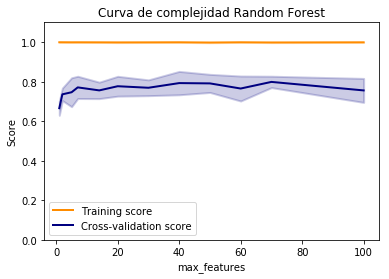

In [69]:
##### Curva de complejidad para Random Forest variando 'max_features'
                                                    
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True) 
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
param_name='max_features'
param_range= [1, 2, 5, 7, 14, 20, 30, 40, 50, 60, 70, 100]
cc_train_scores, cc_valid_scores = sklearn.model_selection.validation_curve(RandomForestClassifier(n_estimators = 10),
                                                                            X_dev_np, y_dev_np, 
                                                                            param_name=param_name, param_range=param_range,
                                                                            cv = cv, scoring='roc_auc')
                                                    
cc_train_scores_mean = np.mean(cc_train_scores, axis=1)
cc_train_scores_std = np.std(cc_train_scores, axis=1)
cc_test_scores_mean = np.mean(cc_valid_scores, axis=1)
cc_test_scores_std = np.std(cc_valid_scores, axis=1)

plot_curve("Curva de complejidad Random Forest",param_name,param_range,cc_train_scores_mean,cc_train_scores_std,cc_test_scores_mean,cc_test_scores_std)


En el gráfico se puede ver que variar el parámetro **max_features** no produce grandes cambios en la performance del modelo. Esto podría ser debido a que con una cantidad tan grande de árboles, aún si estos tienen pocas features, andan muy bien. La curva de complejidad se mantiene "chata" y parece decrecer monotamente apartir de 70. Igualmente usando **max_features = 50** se obtiene el máximo **mean_score_validation** (AUC ROC).

#### Curva de aprendizaje para Random Forest

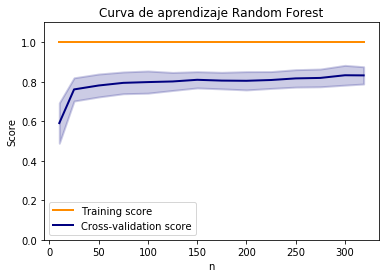

In [70]:
np.random.seed(1234)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5 , shuffle=True)
train_sizes=[10,25, 50, 75, 100,125, 150, 175, 200, 225, 250, 275, 300, 319]
#shufflea con el seed de arriba, manteniendo proporciones de datos por fold.
ca_train_sizes, ca_train_scores, ca_valid_scores = sklearn.model_selection.learning_curve(
    RandomForestClassifier(n_estimators = 200, max_features = 50), X_dev_np, y_dev_np, 
    train_sizes=train_sizes, cv=cv, scoring='roc_auc')
    
ca_train_scores_mean = np.mean(ca_train_scores, axis=1)
ca_train_scores_std = np.std(ca_train_scores, axis=1)
ca_test_scores_mean = np.mean(ca_valid_scores, axis=1)
ca_test_scores_std = np.std(ca_valid_scores, axis=1)
    
plot_curve("Curva de aprendizaje Random Forest",'n',ca_train_sizes,ca_train_scores_mean,ca_train_scores_std,
           ca_test_scores_mean,ca_test_scores_std)
  

No necesitamos aumentar la cantidad de datos ya que la curva de aprendizaje llega a un plateau cuando $50<n<100$ (aprox.) y los folds que son usados para entrenar los modelos tienen $n = 320$. Inclusive apartir de $n=300$, parece volverse constante.

In [78]:
from sklearn.metrics import roc_auc_score
svm = LinearSVC(C=0.001, loss='hinge', max_iter=100, tol=0.4)
rf = RandomForestClassifier(n_estimators = 50, max_features = 'sqrt')
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.82, priors=[0.88, 0.12])
knn = KNeighborsClassifier(n_neighbors=83, weights='uniform', p=1)

X_eval_np = np.array(X_eval)
y_eval_np = np.array(y_eval).ravel()

svm.fit(X_dev_np, y_dev_np)
svm_predict = svm.predict(X_eval_np)
roc_svm = roc_auc_score(y_eval_np, svm_predict)

rf.fit(X_dev_np, y_dev_np)
rf_predict = rf.predict(X_eval_np)
roc_rf = roc_auc_score(y_eval_np, rf_predict)

lda.fit(X_dev_np, y_dev_np)
lda_predict = lda.predict(X_eval_np)
roc_lda = roc_auc_score(y_eval_np, lda_predict)

knn.fit(X_dev_np, y_dev_np)
knn_predict = knn.predict(X_eval_np)
roc_knn = roc_auc_score(y_eval_np, knn_predict)



df = pd.DataFrame(index=range(1,5))
df.index.name = "Modelo"
                  
df["Modelo"] = ["SVM", "Random Forest", "LDA", "KNN"]     # cambiar por accuracies_training
df["AUC ROC"] = [roc_svm, roc_rf, roc_lda, roc_knn]

display(HTML("<h3> TABLA 1 </h3>"))
display(df)



,Modelo,AUC ROC
Modelo,,
1,SVM,0.7013
2,Random Forest,0.7351
3,LDA,0.7118
4,KNN,0.7242


In [82]:
X_competencia_np =np.array(X_competencia)

comp_rf_pred = rf.predict_proba(X_competencia_np)
comp_rf_pred_np = np.array(comp_rf_pred)[:,1]
idx = range(501, 501+len(comp_rf_pred_np))
res = np.zeros((len(idx), 2))
for i in range(len(idx)):
    res[i][0] = idx[i]
    res[i][1] = comp_rf_pred_np[i]
np.savetxt('y_competencia.csv', res, delimiter=',', fmt='%.4f' )

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.


#### Competencia

El mejor modelo de los que exploramos es RandomForestClassifier con $n$_$estimators=50$ y $max$_$features=sqrt$, obtuvo un AUC ROC estimado de 0.7351.